# Audio Classification (Music-Speech Dataset)

###   Importing Libraries

In [6]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
print("Tenserflow version:", tf.__version__)

Tenserflow version: 2.5.0


In [9]:
fdataset = tfds.load("gtzan_music_speech", shuffle_files=False)

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incompleteYPJ8CM/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


### Explolatory Data Analysis

In [10]:
train = dataset["train"]

data_iter = iter(train)

In [11]:
example = next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [12]:
audio = example.get("audio")
label = example.get("label")

print(label.numpy())

Audio(audio, rate=22050)

0


In [13]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [14]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

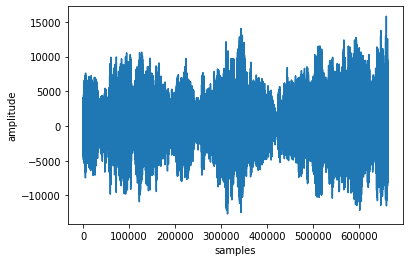

In [15]:
plot_waveform(audio)

### Creating the Spectrogram

In [16]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    """Short-time Fourier transform for audio"""
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [17]:
audio_stft = get_stft(audio)
# ignore relativephasecomponent
audio_spec = tf.abs(audio_stft)
audio_spec

<tf.Tensor: shape=(1288, 129), dtype=float32, numpy=
array([[ 4619.413   ,  2095.692   ,  1997.4834  , ...,    34.180542,
           26.029825,    26.036377],
       [ 2427.6772  ,  3044.5437  ,  1752.5327  , ...,   269.63693 ,
          266.11234 ,   259.75146 ],
       [ 1059.03    ,  4993.912   ,  3935.156   , ...,   228.54843 ,
          227.52249 ,   224.00647 ],
       ...,
       [ 4527.381   ,  1992.1156  ,   846.8434  , ...,   223.70984 ,
          226.92464 ,   235.65308 ],
       [ 3790.2402  ,  4180.1274  ,  6556.6533  , ...,   387.22342 ,
          381.62915 ,   380.39734 ],
       [ 9609.664   ,  6624.39    , 11029.157   , ...,   211.88875 ,
          211.00948 ,   220.76904 ]], dtype=float32)>

In [18]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

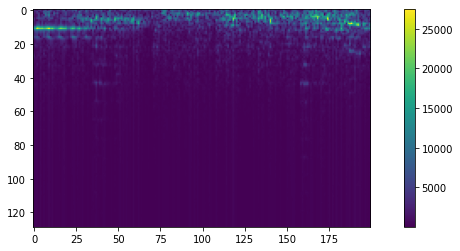

In [19]:
plot_spec(audio_spec[:200])

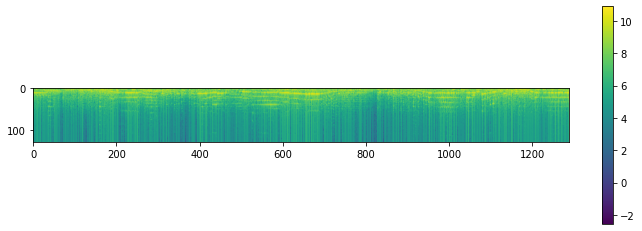

In [20]:
# To mimick human hearing
audio_spec_log = tf.math.log(audio_spec)

plot_spec(audio_spec_log)

In [21]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

### Data Preprocessing

In [22]:
sr = 22050 # samples per second
chunk_len = 5 # seconds

def preprocess_example(example):
    audio = example.get("audio")
    label = example.get("label")

    x_batch, y_batch = None, None

    for i in range(0, 6):
        start_sample = i*chunk_len *sr
        end_sample = (i+1) * chunk_len * sr
        audio_chunk = audio[start_sample: end_sample]

        audio_spec = get_spectrogram(audio_chunk)
        audio_spec = tf.expand_dims(audio_spec, axis=0)

        correct_label = tf.expand_dims(label, axis=0)
        
        x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis=0) 
        y_batch = correct_label if y_batch is None else tf.concat([y_batch, correct_label], axis=0) 

    return x_batch, y_batch

In [23]:
X_train, y_train = None, None

for example in tqdm(iter(train)):
    x_batch, y_batch = preprocess_example(example)

    X_train = x_batch if X_train is None else tf.concat([X_train, x_batch], axis=0) 
    y_train = y_batch if y_train is None else tf.concat([y_train, y_batch], axis=0) 

128it [00:04, 28.52it/s]


In [24]:
print(X_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [25]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(X_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

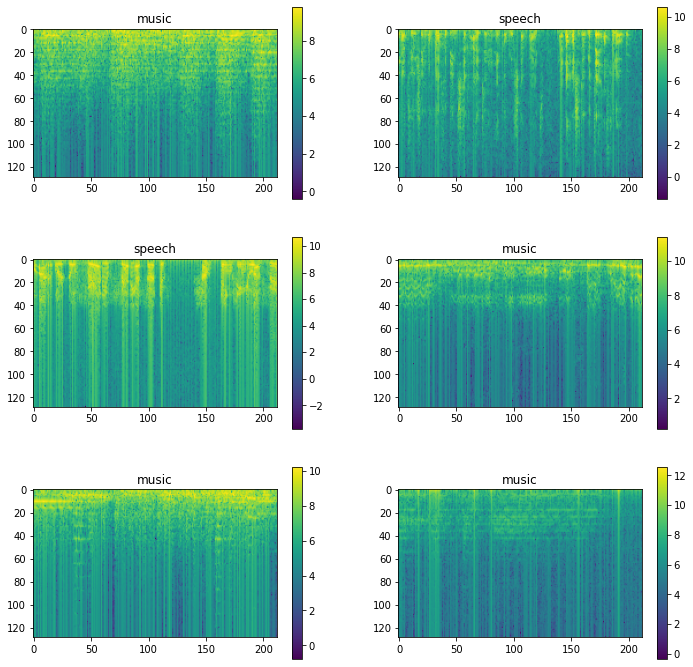

In [26]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

### Building the Model

In [27]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

In [28]:
input_ = Input(shape=(129, 212))
x = Lambda(lambda x: tf.expand_dims(x,axis=-1))(input_)

for i in range(4):
    num_filters = 2**(5+1)
    x= Conv2D(num_filters, 3)(x)
    x = BatchNormalization()(x)
    x = Activation("tanh")(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(input_, x)

In [29]:
model.compile(
    loss="binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics=["accuracy"]
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 210, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 210, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 127, 210, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 105, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 103, 64)       36928 

### Model Training

In [31]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [32]:
model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=12,
    epochs=500,
    verbose=1,
    callbacks=[CustomCallback()]
)

Epoch 1/500
 4/39 [==>...........................] - ETA: 0s - loss: 0.8911 - accuracy: 0.4792   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_train_batch_end` time: 0.0110s). Check your callbacks.


39/39 [==============================] - 33s 34ms/step - loss: 0.8560 - accuracy: 0.4808 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 2/500
39/39 [==============================] - 1s 28ms/step - loss: 0.7981 - accuracy: 0.5363 - val_loss: 0.7240 - val_accuracy: 0.5033
Epoch 3/500
39/39 [==============================] - 1s 24ms/step - loss: 0.7323 - accuracy: 0.5962 - val_loss: 0.7349 - val_accuracy: 0.5067
Epoch 4/500
39/39 [==============================] - 1s 28ms/step - loss: 0.7553 - accuracy: 0.5791 - val_loss: 0.7092 - val_accuracy: 0.5167
Epoch 5/500
39/39 [==============================] - 1s 28ms/step - loss: 0.7411 - accuracy: 0.5833 - val_loss: 0.6808 - val_accuracy: 0.5600
Epoch:   4, Loss: 0.7411, Acc: 0.5833, Val Loss: 0.6808, Val Acc: 0.5600
Epoch 6/500
39/39 [==============================] - 1s 28ms/step - loss: 0.6730 - accuracy: 0.6432 - val_loss: 0.6385 - val_accuracy: 0.6000
Epoch 7/500
39/39 [==============================] - 1s 28ms/step - loss: 0.6765 - acc

### Predictions

In [43]:
example = next(data_iter)

x_test, y_test = preprocess_example(example)

preds = model.predict(x_test)
pred_classes = tf.squeeze(tf.cast(preds > 0.5, tf.int8))

In [44]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [45]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>